In [7]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 
from tqdm import tqdm
from PIL import Image

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import voxelmorph as vxm
from skimage.io import imread, imshow, imsave
from skimage.color import rgb2gray
from PIL import Image
import scipy
import cv2
import tensorflow as tf
import neurite as ne

import helpers

import skimage
from skimage import data, color, transform
from skimage.color import rgb2gray
from skimage.filters import meijering, sato, frangi, hessian
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches,
                             hessian_matrix, hessian_matrix_eigvals,
                             hog)
from skimage.transform import ProjectiveTransform, SimilarityTransform, warp
from skimage.measure import ransac
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import structural_similarity as str_sim
from skimage.io import imread, imshow, imsave

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
DATA_DIR = "/data/ml4s2021/data/2021_11_12/OphtalmoLaus"
OUTPUT_DIR = "/home/ch_taha_zakariya/Desktop/outputs"

## Data loading

Let's start by loading data and grouping it to facilitate the obtention of source/target pairs for training.

In [9]:
images_df = helpers.load_df(DATA_DIR)
images_df.head()

,patient_id,eye,centrage,num,path
0,1,L,OHN,00002,1-20211006-L-cfi-OHN-OphtalmoLaus-00002.jpg
1,1,L,macula,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg
2,1,L,macula,00001,1-20211006-L-cfi-macula-OphtalmoLaus-00001.jpg
3,1,L,macula,00004,1-20211006-L-cfi-macula-OphtalmoLaus-00004.jpg
4,1,L,macula,00005,1-20211006-L-cfi-macula-OphtalmoLaus-00005.jpg


In [10]:
len(images_df)

4097

In [11]:
grouped_df = images_df.groupby(['patient_id', 'eye', 'centrage'], as_index=False)

target_df = grouped_df.first()
target_df[target_df['patient_id'] == '2']

,patient_id,eye,centrage,num,path
519,2,L,LQ,00001,2-20190807-L-cfi-LQ-OphtalmoLaus-00001.jpg
520,2,L,OHN,00002,2-20190807-L-cfi-OHN-OphtalmoLaus-00002.jpg
521,2,L,macula,00000,2-20190807-L-cfi-macula-OphtalmoLaus-00000.jpg
522,2,R,LQ,00000,2-20190807-R-cfi-LQ-OphtalmoLaus-00000.jpg
523,2,R,OHN,00002,2-20190807-R-cfi-OHN-OphtalmoLaus-00002.jpg
524,2,R,macula,00001,2-20190807-R-cfi-macula-OphtalmoLaus-00001.jpg


In [12]:
df = pd.merge(
    target_df,
    images_df,
    how='inner',
    on=['patient_id', 'eye', 'centrage'],
    suffixes=('_target', '_source')
)
df = df[df['num_target'] != df['num_source']]
print(df.shape)
df[df['patient_id'] == '1']

(1984, 7)


,patient_id,eye,centrage,num_target,path_target,num_source,path_source
2,1,L,macula,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,00001,1-20211006-L-cfi-macula-OphtalmoLaus-00001.jpg
3,1,L,macula,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,00004,1-20211006-L-cfi-macula-OphtalmoLaus-00004.jpg
4,1,L,macula,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,00005,1-20211006-L-cfi-macula-OphtalmoLaus-00005.jpg
7,1,R,macula,00000,1-20211006-R-cfi-macula-OphtalmoLaus-00000.jpg,00001,1-20211006-R-cfi-macula-OphtalmoLaus-00001.jpg
8,1,R,macula,00000,1-20211006-R-cfi-macula-OphtalmoLaus-00000.jpg,00004,1-20211006-R-cfi-macula-OphtalmoLaus-00004.jpg
9,1,R,macula,00000,1-20211006-R-cfi-macula-OphtalmoLaus-00000.jpg,00005,1-20211006-R-cfi-macula-OphtalmoLaus-00005.jpg


## Augmenting

Given the nature of the problem, we need a lot of data and some sort of ground truth, which we'll obtain by leveraging augmented data. <br>
Due to the way VoxelMoprh (the only available model for registration) is implemented, we also need squared, greyscale, and little images, otherwise either the algorithm fails to run or consumes too much memory.<br>
To achieve that, we'll preprocess our data and augment it below.

In [13]:
def square(img):
    x_size, y_size = img.shape
    pad = int(abs(y_size-x_size)/2)
    img = img[:, pad:y_size-pad]
    return img

In [14]:
def preprocess(img):
    im = rgb2gray(img)
    im = square(im)
    im = scipy.ndimage.zoom(im, 0.3144)
    return im

In [15]:
AUGMENTED_DIR = '/home/ch_taha_zakariya/Desktop/augmented'

In [16]:
L_macula = [path for path in os.listdir(DATA_DIR) if '-L-' in path and 'macula' in path]
L_macula[0:5]

['9178-20200812-L-cfi-macula-OphtalmoLaus-00002.jpg',
 '336-20190829-L-cfi-macula-OphtalmoLaus-00000.jpg',
 '118-20191107-L-cfi-macula-OphtalmoLaus-00004.jpg',
 '954-20191128-L-cfi-macula-OphtalmoLaus-00004.jpg',
 '9219-20191218-L-cfi-macula-OphtalmoLaus-00001.jpg']

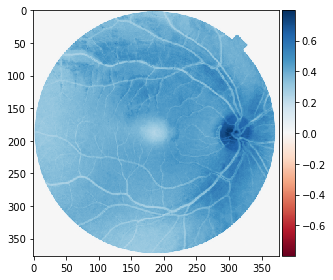

In [18]:
imshow(preprocess(imread('/data/ml4s2021/RESULT_CODE/arruat_wiorowski_zakariya/public/Experiments_cross_correlation/public_source.jpg')))

Save preprocessed data in a file to use it directly

In [157]:
for img_path in tqdm(L_macula):
    im = imread(f'{DATA_DIR}/{img_path}')
    im = preprocess(im)
    imsave(f'{AUGMENTED_DIR}/{img_path}', im)
    rot = random.randint(-20,20)
    trans_x = random.randint(-10,10)
    trans_y = random.randint(-15,15)
    im = transform.rotate(im, rot)
    im = transform.warp(im, transform.SimilarityTransform(translation=(trans_x,trans_y)))
    #im = Image.fromarray(np.uint8(im))
    imsave(f'{AUGMENTED_DIR}/augmented_{img_path}', im)

  0%|                                                  | 0/1091 [00:00<?, ?it/s]Lossy conversion from float64 to uint8. Range [-0.0027162714658594306, 0.7515554301736395]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0009960968559745017, 0.7403147690286924]. Convert image to uint8 prior to saving to suppress this warning.
  0%|                                          | 1/1091 [00:00<08:55,  2.04it/s]Lossy conversion from float64 to uint8. Range [-0.002615610152745802, 0.6919808053659996]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0011228649394820261, 0.683605847982278]. Convert image to uint8 prior to saving to suppress this warning.
  0%|                                          | 2/1091 [00:00<08:41,  2.09it/s]Lossy conversion from float64 to uint8. Range [-0.0025802588112503804, 0.7830123356720653]. Convert image to uint8 prior to saving to 

  2%|▊                                        | 21/1091 [00:10<08:52,  2.01it/s]Lossy conversion from float64 to uint8. Range [-0.0016698126081622613, 0.806001940627262]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0004430427298572655, 0.8028475593186637]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▊                                        | 22/1091 [00:10<08:52,  2.01it/s]Lossy conversion from float64 to uint8. Range [-0.0021814356345702616, 0.5511497753702671]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.00073353020981894, 0.534241875448282]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▊                                        | 23/1091 [00:11<08:48,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.002950753944896763, 0.8473728022268047]. Convert image to uint8 prior to saving to sup

  4%|█▌                                       | 42/1091 [00:20<08:44,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0025809805885795237, 0.7382429460260881]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007262449785124976, 0.7319813553431241]. Convert image to uint8 prior to saving to suppress this warning.
  4%|█▌                                       | 43/1091 [00:20<08:40,  2.01it/s]Lossy conversion from float64 to uint8. Range [-0.00225424600747886, 0.6879593829651801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008916567512829677, 0.6799921029939033]. Convert image to uint8 prior to saving to suppress this warning.
  4%|█▋                                       | 44/1091 [00:21<08:43,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0020785394094864815, 0.9820472340930799]. Convert image to uint8 prior to saving to 

  8%|███▏                                     | 84/1091 [00:41<08:11,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.0021095926656990384, 0.7104547562836313]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.00054350417516204, 0.7079620000539139]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███▏                                     | 85/1091 [00:41<08:07,  2.07it/s]Lossy conversion from float64 to uint8. Range [-0.0023589939255740026, 0.9181025394991916]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0011507595885726423, 0.9162256816545298]. Convert image to uint8 prior to saving to suppress this warning.
  8%|███▏                                     | 86/1091 [00:42<08:04,  2.07it/s]Lossy conversion from float64 to uint8. Range [-0.002062688602207168, 0.705800784437847]. Convert image to uint8 prior to saving to su

 10%|███▊                                    | 105/1091 [00:51<08:06,  2.03it/s]Lossy conversion from float64 to uint8. Range [-0.0021467558167530694, 0.9763888981166943]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0010733165375076358, 0.976048059041702]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███▉                                    | 106/1091 [00:52<08:07,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.00267792868241425, 0.6450181653657828]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0020012194864528028, 0.6357625761750613]. Convert image to uint8 prior to saving to suppress this warning.
 10%|███▉                                    | 107/1091 [00:52<08:08,  2.01it/s]Lossy conversion from float64 to uint8. Range [-0.0018491560331021937, 0.9613703464418178]. Convert image to uint8 prior to saving to s

 13%|█████▍                                  | 147/1091 [01:12<07:52,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0023724106171019734, 0.6705858563791405]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008045619779040492, 0.6626843311550282]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████▍                                  | 148/1091 [01:12<07:51,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.002019574888440488, 0.7487872224686745]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008031119532143857, 0.7396880423810508]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████▍                                  | 149/1091 [01:13<07:47,  2.01it/s]Lossy conversion from float64 to uint8. Range [-0.0024234514766368212, 0.7452484197039897]. Convert image to uint8 prior to saving to

 17%|██████▉                                 | 189/1091 [01:32<07:00,  2.15it/s]Lossy conversion from float64 to uint8. Range [-0.0018985026335028654, 0.9387340123832922]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0010485869438115582, 0.9360982687340811]. Convert image to uint8 prior to saving to suppress this warning.
 17%|██████▉                                 | 190/1091 [01:32<06:59,  2.15it/s]Lossy conversion from float64 to uint8. Range [-0.0018806525565068853, 0.8297501767778863]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0006686273234896013, 0.809793796195655]. Convert image to uint8 prior to saving to suppress this warning.
 18%|███████                                 | 191/1091 [01:33<06:54,  2.17it/s]Lossy conversion from float64 to uint8. Range [-0.003352735420274747, 0.478653883908957]. Convert image to uint8 prior to saving to s

 19%|███████▋                                | 210/1091 [01:41<07:06,  2.07it/s]Lossy conversion from float64 to uint8. Range [-0.0023862704489057114, 0.8577782008480311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0010017703275425826, 0.8570280661103644]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████▋                                | 211/1091 [01:42<07:08,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.0022187524511914497, 0.96405374902234]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.00040719751933490606, 0.9597738099273655]. Convert image to uint8 prior to saving to suppress this warning.
 19%|███████▊                                | 212/1091 [01:42<06:56,  2.11it/s]Lossy conversion from float64 to uint8. Range [-0.0026382342181349994, 0.695819659210423]. Convert image to uint8 prior to saving to 

 23%|█████████▏                              | 252/1091 [02:02<06:48,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.0019514348584957213, 0.8455171699340136]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007381190303806396, 0.8427898648164893]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████▎                              | 253/1091 [02:02<06:49,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.002386055688560805, 0.7438312790638351]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0013073204109724345, 0.7404645773080805]. Convert image to uint8 prior to saving to suppress this warning.
 23%|█████████▎                              | 254/1091 [02:03<06:43,  2.07it/s]Lossy conversion from float64 to uint8. Range [-0.002228397134344751, 0.8814496260065915]. Convert image to uint8 prior to saving to 

 25%|██████████                              | 273/1091 [02:13<07:26,  1.83it/s]Lossy conversion from float64 to uint8. Range [-0.0018500966681787305, 0.8877805837898133]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007631569255802581, 0.8858696716055954]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████                              | 274/1091 [02:13<07:18,  1.87it/s]Lossy conversion from float64 to uint8. Range [-0.001976179028884114, 0.8440817801288857]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007435872708491767, 0.8410632080283321]. Convert image to uint8 prior to saving to suppress this warning.
 25%|██████████                              | 275/1091 [02:14<07:15,  1.88it/s]Lossy conversion from float64 to uint8. Range [-0.002152462711890249, 0.7675508025177947]. Convert image to uint8 prior to saving to 

 27%|██████████▊                             | 294/1091 [02:23<06:47,  1.96it/s]Lossy conversion from float64 to uint8. Range [-0.001728238481203205, 0.7467370192151105]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007622290206375348, 0.7427641686619084]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████▊                             | 295/1091 [02:24<06:43,  1.97it/s]Lossy conversion from float64 to uint8. Range [-0.0020584844237191476, 0.8023691243474813]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0014829721952548077, 0.7973229147256835]. Convert image to uint8 prior to saving to suppress this warning.
 27%|██████████▊                             | 296/1091 [02:24<06:34,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.0020863818677560723, 0.6176043048365714]. Convert image to uint8 prior to saving to

 31%|████████████▎                           | 336/1091 [02:44<05:55,  2.12it/s]Lossy conversion from float64 to uint8. Range [-0.0017675032300563489, 0.9104175549449913]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008902446743740916, 0.9054725322769944]. Convert image to uint8 prior to saving to suppress this warning.
 31%|████████████▎                           | 337/1091 [02:44<05:56,  2.12it/s]Lossy conversion from float64 to uint8. Range [-0.00212159087670486, 0.8259842051143709]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0005531385489723888, 0.8220763691440287]. Convert image to uint8 prior to saving to suppress this warning.
 31%|████████████▍                           | 338/1091 [02:45<05:54,  2.12it/s]Lossy conversion from float64 to uint8. Range [-0.002016989885530598, 0.7968404490390741]. Convert image to uint8 prior to saving to s

 33%|█████████████                           | 357/1091 [02:54<06:06,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0025166776394139217, 0.7432671861243332]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0012676331099411057, 0.7378144777624832]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████▏                          | 358/1091 [02:54<06:03,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.002366560389017766, 1.0015040761485041]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007627198216002787, 0.9992049821278336]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████▏                          | 359/1091 [02:55<06:01,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.002099970123088483, 0.705197619825734]. Convert image to uint8 prior to saving to s

 37%|██████████████▋                         | 399/1091 [03:14<05:35,  2.06it/s]Lossy conversion from float64 to uint8. Range [-0.0025819595200568587, 0.7617445552475894]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.000924160880250899, 0.7581988178109955]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████▋                         | 400/1091 [03:15<05:35,  2.06it/s]Lossy conversion from float64 to uint8. Range [-0.0025958740580802487, 0.8256245052542289]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008021675028130496, 0.8152925746672326]. Convert image to uint8 prior to saving to suppress this warning.
 37%|██████████████▋                         | 401/1091 [03:15<05:35,  2.06it/s]Lossy conversion from float64 to uint8. Range [-0.00233649992371708, 0.9093968491082633]. Convert image to uint8 prior to saving to s

 38%|███████████████▍                        | 420/1091 [03:25<05:36,  1.99it/s]Lossy conversion from float64 to uint8. Range [-0.0032602335483098077, 1.0002898319385833]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0003020048617870722, 0.9993406038680723]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████▍                        | 421/1091 [03:26<05:36,  1.99it/s]Lossy conversion from float64 to uint8. Range [-0.002297224813153769, 0.9648938931073947]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0006078136941731138, 0.9369036780312043]. Convert image to uint8 prior to saving to suppress this warning.
 39%|███████████████▍                        | 422/1091 [03:26<05:35,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.00259543690586794, 0.7946038870358306]. Convert image to uint8 prior to saving to s

 40%|████████████████▏                       | 441/1091 [03:36<05:21,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.0020438015777018157, 0.8940322269290911]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.00040280920823036086, 0.8865621492640704]. Convert image to uint8 prior to saving to suppress this warning.
 41%|████████████████▏                       | 442/1091 [03:36<05:21,  2.02it/s]Lossy conversion from float64 to uint8. Range [-0.00323934999939519, 0.7989155792214031]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007134156311363528, 0.7859450563831335]. Convert image to uint8 prior to saving to suppress this warning.
 41%|████████████████▏                       | 443/1091 [03:37<05:23,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.002018226015226231, 1.0013922954044316]. Convert image to uint8 prior to saving to 

 42%|████████████████▉                       | 462/1091 [03:46<05:16,  1.99it/s]Lossy conversion from float64 to uint8. Range [-0.001970754944395407, 0.7205390264716285]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0006763014693672181, 0.718210123670783]. Convert image to uint8 prior to saving to suppress this warning.
 42%|████████████████▉                       | 463/1091 [03:47<05:13,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0026995912311465553, 0.7107097622031503]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0009319576474550465, 0.7009169659962167]. Convert image to uint8 prior to saving to suppress this warning.
 43%|█████████████████                       | 464/1091 [03:47<05:13,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0023784483537538977, 0.7583095373316036]. Convert image to uint8 prior to saving to 

 46%|██████████████████▍                     | 504/1091 [04:07<04:36,  2.12it/s]Lossy conversion from float64 to uint8. Range [-0.002443808823399774, 0.785553677761358]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.000536895127993735, 0.7815007808163592]. Convert image to uint8 prior to saving to suppress this warning.
 46%|██████████████████▌                     | 505/1091 [04:08<04:41,  2.09it/s]Lossy conversion from float64 to uint8. Range [-0.0022688601410075686, 0.7076274669273319]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0006123963038595114, 0.6952165262582596]. Convert image to uint8 prior to saving to suppress this warning.
 46%|██████████████████▌                     | 506/1091 [04:08<04:40,  2.08it/s]Lossy conversion from float64 to uint8. Range [-0.0024072677239446202, 0.7653305181341604]. Convert image to uint8 prior to saving to s

 48%|███████████████████▏                    | 525/1091 [04:17<04:29,  2.10it/s]Lossy conversion from float64 to uint8. Range [-0.0019968525952498506, 0.718987612463459]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007592142493780949, 0.71238288973557]. Convert image to uint8 prior to saving to suppress this warning.
 48%|███████████████████▎                    | 526/1091 [04:18<04:28,  2.10it/s]Lossy conversion from float64 to uint8. Range [-0.0017690322221849699, 0.7530752903742406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.000268808485424668, 0.7454592934118052]. Convert image to uint8 prior to saving to suppress this warning.
 48%|███████████████████▎                    | 527/1091 [04:18<04:27,  2.11it/s]Lossy conversion from float64 to uint8. Range [-0.0020144439944554107, 0.6917514014901378]. Convert image to uint8 prior to saving to su

 50%|████████████████████                    | 546/1091 [04:27<04:18,  2.11it/s]Lossy conversion from float64 to uint8. Range [-0.0018478745039302077, 0.8172095852772354]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008371846636408718, 0.815138615714819]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████                    | 547/1091 [04:28<04:20,  2.08it/s]Lossy conversion from float64 to uint8. Range [-0.008199525732516024, 0.9670329530511387]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.00032856507817369664, 0.9298584098137581]. Convert image to uint8 prior to saving to suppress this warning.
 50%|████████████████████                    | 548/1091 [04:28<03:58,  2.27it/s]Lossy conversion from float64 to uint8. Range [-0.002622870382735498, 0.9014427799752621]. Convert image to uint8 prior to saving to 

 54%|█████████████████████▌                  | 588/1091 [04:48<04:17,  1.95it/s]Lossy conversion from float64 to uint8. Range [-0.0018461065034490194, 0.6906773157692595]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.001270947196737718, 0.6827209601660716]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████▌                  | 589/1091 [04:49<04:19,  1.94it/s]Lossy conversion from float64 to uint8. Range [-0.0030933036976425092, 0.7264399531270223]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0010743461798898173, 0.7211243634778853]. Convert image to uint8 prior to saving to suppress this warning.
 54%|█████████████████████▋                  | 590/1091 [04:49<04:20,  1.92it/s]Lossy conversion from float64 to uint8. Range [-0.0024363286676266664, 0.8105509620582761]. Convert image to uint8 prior to saving to

 58%|███████████████████████                 | 630/1091 [05:09<03:45,  2.04it/s]Lossy conversion from float64 to uint8. Range [-0.0024042206352474964, 0.7547960594034506]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0024042206352474964, 0.7547960594034506]. Convert image to uint8 prior to saving to suppress this warning.
 58%|███████████████████████▏                | 631/1091 [05:09<03:44,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.002477389428103937, 0.8911115977290547]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0005447724609275123, 0.8853073265803086]. Convert image to uint8 prior to saving to suppress this warning.
 58%|███████████████████████▏                | 632/1091 [05:10<03:44,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.0016723384699217582, 0.8546807090144986]. Convert image to uint8 prior to saving to

 62%|████████████████████████▋               | 672/1091 [05:29<03:29,  2.00it/s]Lossy conversion from float64 to uint8. Range [-0.0024823354127329732, 1.0005160151310222]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.001114659243534588, 0.9993606299705551]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████▋               | 673/1091 [05:30<03:34,  1.95it/s]Lossy conversion from float64 to uint8. Range [-0.0026520301352876002, 0.5784858870992422]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0002836837663703181, 0.5760179732463655]. Convert image to uint8 prior to saving to suppress this warning.
 62%|████████████████████████▋               | 674/1091 [05:31<03:34,  1.94it/s]Lossy conversion from float64 to uint8. Range [-0.004113404082778776, 0.7965340005109354]. Convert image to uint8 prior to saving to 

 65%|██████████████████████████▏             | 714/1091 [05:51<03:11,  1.97it/s]Lossy conversion from float64 to uint8. Range [-0.001834600132207496, 0.90214284120486]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████▏             | 715/1091 [05:51<03:07,  2.01it/s]Lossy conversion from float64 to uint8. Range [-0.0024473318897081904, 0.7483395257406734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0010357278514075753, 0.7293601167928383]. Convert image to uint8 prior to saving to suppress this warning.
 66%|██████████████████████████▎             | 716/1091 [05:52<03:04,  2.03it/s]Lossy conversion from float64 to uint8. Range [-0.002018323942937141, 0.6700623546256632]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

 69%|███████████████████████████▋            | 756/1091 [06:11<02:39,  2.09it/s]Lossy conversion from float64 to uint8. Range [-0.0017381058265990314, 0.9410939130360801]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0009212790596710355, 0.9402838179147011]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████▊            | 757/1091 [06:12<02:39,  2.10it/s]Lossy conversion from float64 to uint8. Range [-0.002287507679399533, 0.6029481251256056]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 69%|███████████████████████████▊            | 758/1091 [06:12<02:24,  2.31it/s]Lossy conversion from float64 to uint8. Range [-0.0022599352861729007, 0.7904114875071182]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversi

 73%|█████████████████████████████▎          | 798/1091 [06:32<02:23,  2.04it/s]Lossy conversion from float64 to uint8. Range [-0.00199055274123706, 0.9363761880879341]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0011566674073051433, 0.9338028286808266]. Convert image to uint8 prior to saving to suppress this warning.
 73%|█████████████████████████████▎          | 799/1091 [06:32<02:22,  2.05it/s]Lossy conversion from float64 to uint8. Range [-0.0021389248303218204, 0.7636025808891345]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0012948248577348727, 0.7527352869494517]. Convert image to uint8 prior to saving to suppress this warning.
 73%|█████████████████████████████▎          | 800/1091 [06:33<02:23,  2.03it/s]Lossy conversion from float64 to uint8. Range [-0.0020285900745891463, 0.905694049769001]. Convert image to uint8 prior to saving to s

 75%|██████████████████████████████          | 819/1091 [06:42<02:10,  2.09it/s]Lossy conversion from float64 to uint8. Range [-0.0023731741662426265, 0.7155093241273767]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0012020540356366385, 0.711092965758021]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████          | 820/1091 [06:43<02:09,  2.09it/s]Lossy conversion from float64 to uint8. Range [-0.0023954932273699387, 0.8101794067798352]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0012285843292107004, 0.8082924209031099]. Convert image to uint8 prior to saving to suppress this warning.
 75%|██████████████████████████████          | 821/1091 [06:43<02:08,  2.10it/s]Lossy conversion from float64 to uint8. Range [-0.001963933743910333, 0.9896658057718213]. Convert image to uint8 prior to saving to 

 77%|██████████████████████████████▊         | 840/1091 [06:52<01:39,  2.52it/s]Lossy conversion from float64 to uint8. Range [-0.0024150454468040497, 0.7438970427169018]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0003711607355176176, 0.7416910087818964]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████▊         | 841/1091 [06:52<01:37,  2.56it/s]Lossy conversion from float64 to uint8. Range [-0.004166204702592637, 0.5836014677032151]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 77%|██████████████████████████████▊         | 842/1091 [06:52<01:36,  2.57it/s]Lossy conversion from float64 to uint8. Range [-0.0020612819907866783, 1.0019662727720786]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversi

 81%|████████████████████████████████▎       | 882/1091 [07:08<01:24,  2.48it/s]Lossy conversion from float64 to uint8. Range [-0.00264638120292074, 0.7932282459794068]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.000727582458408283, 0.7861655415775717]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████▎       | 883/1091 [07:09<01:23,  2.48it/s]Lossy conversion from float64 to uint8. Range [-0.002205488497975015, 0.9999819110385625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 81%|████████████████████████████████▍       | 884/1091 [07:09<01:23,  2.47it/s]Lossy conversion from float64 to uint8. Range [-0.002255006391358039, 0.8798918232272191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion f

 85%|█████████████████████████████████▉      | 924/1091 [07:25<01:06,  2.53it/s]Lossy conversion from float64 to uint8. Range [-0.002416145580579657, 1.0034810417170803]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0006153791064512696, 1.0021537594190946]. Convert image to uint8 prior to saving to suppress this warning.
 85%|█████████████████████████████████▉      | 925/1091 [07:25<01:05,  2.52it/s]Lossy conversion from float64 to uint8. Range [-0.0022794483241354627, 0.7824736827359434]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0008908696211384088, 0.7746054948474044]. Convert image to uint8 prior to saving to suppress this warning.
 85%|█████████████████████████████████▉      | 926/1091 [07:25<01:05,  2.54it/s]Lossy conversion from float64 to uint8. Range [-0.002278683124371631, 0.7565239774876035]. Convert image to uint8 prior to saving to 

 89%|███████████████████████████████████▍    | 966/1091 [07:42<00:47,  2.61it/s]Lossy conversion from float64 to uint8. Range [-0.0019859266205326164, 1.001967774077056]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████▍    | 967/1091 [07:42<00:47,  2.61it/s]Lossy conversion from float64 to uint8. Range [-0.0030491249319861847, 0.908575548809213]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0012253002089779425, 0.9010775650171203]. Convert image to uint8 prior to saving to suppress this warning.
 89%|███████████████████████████████████▍    | 968/1091 [07:43<00:47,  2.61it/s]Lossy conversion from float64 to uint8. Range [-0.004878236174180325, 0.782776420366979]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion 

 92%|████████████████████████████████████   | 1008/1091 [07:58<00:33,  2.50it/s]Lossy conversion from float64 to uint8. Range [0.007077101705063471, 1.0015560810424533]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1.0002566569740328]. Convert image to uint8 prior to saving to suppress this warning.
 92%|████████████████████████████████████   | 1009/1091 [07:59<00:32,  2.51it/s]Lossy conversion from float64 to uint8. Range [-0.0022916121612165975, 0.7866425490988267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0013542308181866167, 0.7787372389656045]. Convert image to uint8 prior to saving to suppress this warning.
 93%|████████████████████████████████████   | 1010/1091 [07:59<00:31,  2.55it/s]Lossy conversion from float64 to uint8. Range [-0.002179068682960632, 0.7714457295382292]. Convert image to uint8 prior to saving to suppress this warnin

 94%|████████████████████████████████████▊  | 1029/1091 [08:06<00:23,  2.69it/s]Lossy conversion from float64 to uint8. Range [-0.00241621855284013, 0.7111975592848085]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0005415683212492087, 0.7083692830003461]. Convert image to uint8 prior to saving to suppress this warning.
 94%|████████████████████████████████████▊  | 1030/1091 [08:07<00:22,  2.69it/s]Lossy conversion from float64 to uint8. Range [-0.0025317679954336325, 0.6372491949038962]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
 95%|████████████████████████████████████▊  | 1031/1091 [08:07<00:20,  2.94it/s]Lossy conversion from float64 to uint8. Range [-0.0021874413179254195, 0.6785392458372764]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

Lossy conversion from float64 to uint8. Range [-0.0006458508598548302, 0.9192916955411448]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████▌ | 1051/1091 [08:15<00:18,  2.18it/s]Lossy conversion from float64 to uint8. Range [-0.0018336021563783611, 0.7489267374719797]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007025469863875058, 0.7315131534344204]. Convert image to uint8 prior to saving to suppress this warning.
 96%|█████████████████████████████████████▌ | 1052/1091 [08:16<00:18,  2.09it/s]Lossy conversion from float64 to uint8. Range [-0.002896438862461059, 0.7188032482296298]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.00123306204323728, 0.7172640184956451]. Convert image to uint8 prior to saving to suppress this warning.
 97%|█████████████████████████████████████▋ | 1053/1091 [0

Lossy conversion from float64 to uint8. Range [-0.0009538582972844341, 0.8866972761390808]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████▎| 1072/1091 [08:24<00:07,  2.61it/s]Lossy conversion from float64 to uint8. Range [-0.001835991351812853, 1.0035743099230385]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0007771435919097518, 0.9991130538447147]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████▎| 1073/1091 [08:25<00:06,  2.63it/s]Lossy conversion from float64 to uint8. Range [-0.0019366936305035508, 0.8538173129276472]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.000877649536923995, 0.8512794098367689]. Convert image to uint8 prior to saving to suppress this warning.
 98%|██████████████████████████████████████▍| 1074/1091 [

## Data loading

Below we load left eye macula data that we'll use later to train a part of the dataset, again in a way that facilitates the obtention of source/target pairs.

In [158]:
def load_df_aug(path):
    pattern = "^(augmented_)?(\d+)-(\d+)-([LR])-(cfi|multicolor|other)-(OHN|macula|LQ)-(OphtalmoLaus)-(\d+)\.jpg"
    filenames = [x for x in sorted(os.listdir(path)) if x.endswith('.jpg')]
    def extract(x):
        a = re.search(pattern, x)
        if a is None or not a:
            return None
        return a.groups()
    extracted = list(map(extract, filenames))
    images_df = pd.DataFrame(extracted, columns=['augmented', 'patient_id', 'date', 'eye', 'image_type', 'centrage', 'dataset', 'num'])
    images_df['path'] = filenames
    images_df.sort_values(['augmented', 'patient_id', 'eye', 'centrage', 'num'], inplace=True)
    images_df.drop_duplicates(['augmented', 'patient_id', 'eye', 'image_type', 'centrage', 'dataset', 'num'], inplace=True)
    images_df.drop(['date', 'image_type', 'dataset'], axis=1, inplace=True)
    return images_df

In [159]:
# {}[]\|

In [160]:
df = load_df_aug(AUGMENTED_DIR)
for i in range(len(df)):
    if df['augmented'].iloc[i]=='augmented_':
        df['augmented'].iloc[i] = 1
    else:
        df['augmented'].iloc[i] = 0
        
df.head()

,augmented,patient_id,eye,centrage,num,path
1091,1,1,L,macula,00000,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
1092,1,1,L,macula,00001,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
1093,1,1,L,macula,00004,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
1094,1,1,L,macula,00005,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
1095,1,1004,L,macula,00000,augmented_1004-20201007-L-cfi-macula-OphtalmoL...


In [161]:
g_df = df[df['augmented']==0].groupby(['patient_id', 'eye', 'centrage'], as_index=False)

t_df = g_df.first()
print(len(t_df))
t_df[t_df['patient_id'] == '2']

407


,patient_id,eye,centrage,augmented,num,path
108,2,L,macula,0,00000,2-20190807-L-cfi-macula-OphtalmoLaus-00000.jpg


In [162]:
len(df[df['augmented'] == 1])

1090

In [163]:
df = pd.merge(
    t_df,
    df,
    how='inner',
    on=['patient_id', 'eye', 'centrage'],
    suffixes=('_target', '_source')
)
print(df.shape)
df[df['patient_id'] == '1']

(2180, 9)


,patient_id,eye,centrage,augmented_target,num_target,path_target,augmented_source,num_source,path_source
0,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00000,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
1,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00001,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
2,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00004,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
3,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00005,augmented_1-20211006-L-cfi-macula-OphtalmoLaus...
4,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg
5,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,0,00001,1-20211006-L-cfi-macula-OphtalmoLaus-00001.jpg
6,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,0,00004,1-20211006-L-cfi-macula-OphtalmoLaus-00004.jpg
7,1,L,macula,0,00000,1-20211006-L-cfi-macula-OphtalmoLaus-00000.jpg,0,00005,1-20211006-L-cfi-macula-OphtalmoLaus-00005.jpg


In [164]:
len(df[df['augmented_source'] == 1])

1090

## Learning

In this subsection we'll first do some sanity check to see if VoxelMorph works well by overriding it on 1 pair.
<br>
We'll be working with VoxelMorph as our basis model to test the deep learning method.

#### Sanity check by trying to overfit algo with 1 source 1 target

In [33]:
def preprocess(img):
    im = rgb2gray(img)
    im = square(im)
    im = scipy.ndimage.zoom(im, 0.4)
    return im

In [52]:
source = imread('/data/ml4s2021/RESULT_CODE/arruat_wiorowski_zakariya/public/Experiments_cross_correlation/public_source.jpg')
source = preprocess(source)
rot = random.randint(-10,10)
trans_x = random.randint(-4,4)
trans_y = random.randint(-4,4)
target = transform.rotate(source, rot)
target = transform.warp(target, transform.SimilarityTransform(translation=(trans_x,trans_y)))

In [53]:
sources = source
targets = target
train_set = (sources, targets)

In [54]:
# shape of image
vol_shape = targets.shape#[1:]

inshape = (*vol_shape, 2) # the 2 because it's 2 images

nb_features = [
    [32, 32, 32, 32], # nb encoder features, maybe change nb of features or depth of features
    [32, 32, 32, 32, 32, 16] # nb decoder features
]
ndim = 2

print(sources.shape)
print(vol_shape)
print(inshape)

(480, 480)
(480, 480)
(480, 480, 2)


In [55]:
# unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

In [56]:
print('input shape:', unet.input.shape)
print('output shape:', unet.output.shape)

input shape: (None, 480, 480, 2)
output shape: (None, 480, 480, 16)


In [57]:
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

print('displacement tensor:', disp_tensor.shape)

def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 480, 480, 2)


In [58]:
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])
print("ok")

ok


In [59]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

In [60]:
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# losses = [str_sim, vxm.losses.Grad('l2').loss]

lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [61]:
def vxm_data_generator(sources, targets, batch_size=1):
    
    vol_shape = targets.shape
    ndims = len(vol_shape)
    
    zero_phi = np.zeros([batch_size, *vol_shape, ndims]).astype(float)
    
    while True:
        idx1 = np.random.randint(0, 1, size=batch_size)
        sources_images = sources[np.newaxis, ..., np.newaxis].astype(float)
        targets_images = targets[np.newaxis, ..., np.newaxis].astype(float)
        inputs = [sources_images, targets_images]
        
        outputs = [targets_images, zero_phi]
        
        yield (inputs, outputs)

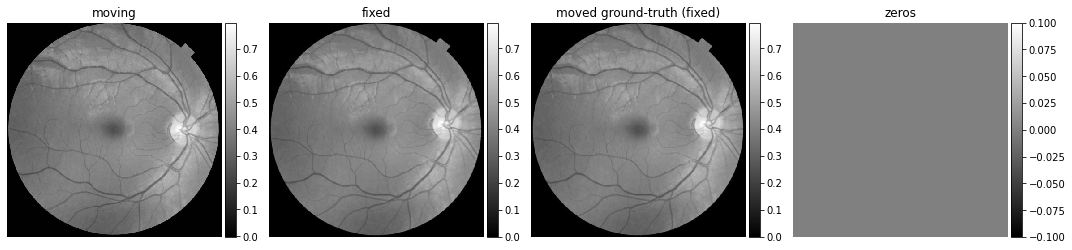

(<Figure size 1080x270 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving'}>,
        <AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'moved ground-truth (fixed)'}>,
        <AxesSubplot:title={'center':'zeros'}>], dtype=object))

In [62]:
train_generator = vxm_data_generator(sources, targets)
in_sample, out_sample = next(train_generator)

# first 0 to take first sample because batch of many samples, last zero to take one channel (i suppose)
# images = [img[0, :, :, 0] for img in in_sample + out_sample]
images = [img[0,:, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [63]:
train_generator = vxm_data_generator(sources, targets)
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)
nb_epochs = 3
steps_per_epoch = 10
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)

/tmp/ipykernel_22683/1174220699.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)


Epoch 1/3
10/10 - 14s - loss: 0.0019 - transformer_loss: 0.0019 - flow_loss: 5.4451e-05 - 14s/epoch - 1s/step
Epoch 2/3
10/10 - 11s - loss: 0.0016 - transformer_loss: 0.0016 - flow_loss: 3.3020e-04 - 11s/epoch - 1s/step
Epoch 3/3
10/10 - 11s - loss: 0.0015 - transformer_loss: 0.0015 - flow_loss: 2.7682e-04 - 11s/epoch - 1s/step


In [64]:
val_generator = vxm_data_generator(sources, targets, batch_size=1)
val_input, _ = next(val_generator)

val_pred = vxm_model.predict(val_input)

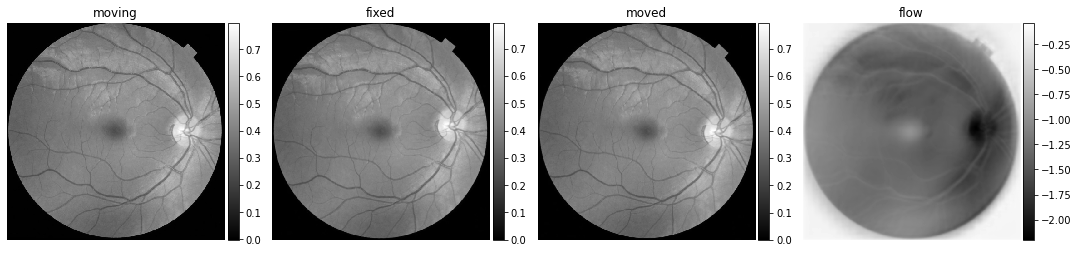

(<Figure size 1080x270 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving'}>,
        <AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'moved'}>,
        <AxesSubplot:title={'center':'flow'}>], dtype=object))

In [65]:
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [70]:
f'Overriding the algorithm with the public pair gives a structural similarity of: {str_sim(np.array(val_pred[0])[0,:,:,0], source)}'

'Overriding the algorithm with the public pair gives a structural similarity of: 0.9415890566941542'

#### Training (on left eye macula data)

In [166]:
split = 0.7
patient_ids = df['patient_id'].drop_duplicates()
training_ids = np.array(patient_ids)[0:int(split*len(patient_ids))]
test_ids = np.array(patient_ids)[int(split*len(patient_ids)):len(patient_ids)]

In [175]:
df_training = df[df['patient_id'].apply(lambda x: x in list(training_ids))]
df_testing = df[df['patient_id'].apply(lambda x: x not in list(training_ids))]
df_testing.head()

,patient_id,eye,centrage,augmented_target,num_target,path_target,augmented_source,num_source,path_source
1382,5383,L,macula,0,00000,5383-20210923-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00000,augmented_5383-20210923-L-cfi-macula-OphtalmoL...
1383,5383,L,macula,0,00000,5383-20210923-L-cfi-macula-OphtalmoLaus-00000.jpg,0,00000,5383-20210923-L-cfi-macula-OphtalmoLaus-00000.jpg
1384,541,L,macula,0,00000,541-20191024-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00000,augmented_541-20191024-L-cfi-macula-OphtalmoLa...
1385,541,L,macula,0,00000,541-20191024-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00001,augmented_541-20191024-L-cfi-macula-OphtalmoLa...
1386,541,L,macula,0,00000,541-20191024-L-cfi-macula-OphtalmoLaus-00000.jpg,1,00003,augmented_541-20191024-L-cfi-macula-OphtalmoLa...


In [176]:
tr_path_target = df_training['path_target']
tr_path_source = df_training['path_source']
te_path_target = df_testing['path_target']
te_path_source = df_testing['path_source']

In [ ]:
sources = np.array([(cv2.imread(f'{AUGMENTED_DIR}/{path}')) for path in tr_path_source])
targets = np.array([cv2.imread(f'{AUGMENTED_DIR}/{path}') for path in tr_path_target])
imshow(sources[5])

In [206]:
train_set = np.array(list(zip(sources, targets)))
testing_set = np.array(list(zip(testing_sources, testing_targets)))

/tmp/ipykernel_8080/2351662531.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_set = np.array(list(zip(sources, targets)))


In [216]:
vol_shape = targets[0].shape
inshape = (*vol_shape, 2)
nb_features = [
    [32, 32, 32, 32],
    [32, 32, 32, 32, 32, 16]
]
ndim = 2

print(targets.shape)
print(vol_shape)
print(inshape)

(1382,)
(608, 608)
(608, 608, 2)


In [226]:
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
#losses = ['mse', vxm.losses.Grad('l2').loss]
#loss_weights = [1, 0.01] vxm.losses.NCC().loss
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.1]

vxm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=losses,
    loss_weights=loss_weights
)

In [255]:
def vxm_data_generator(sources, targets, batch_size=8):
    
    vol_shape = targets[0].shape
    ndims = len(vol_shape)
    
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        idx1 = np.random.randint(0, targets.shape[0], size=batch_size)
        sources_images = sources[[idx1]]
        sources_images = sources_images.apply_along_axis(np.expand_dims, axis=0, )
        targets_images = targets[[idx1]]
        inputs = [sources_images, targets_images]
        print(np.array(inputs).shape)
        outputs = [targets_images, zero_phi]
        
        yield (inputs, outputs)


In [ ]:
train_generator = vxm_data_generator(sources, targets)
in_sample, out_sample = next(train_generator)

images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [ ]:
hist = vxm_model.fit_generator(
    train_generator,
    epochs=1,
    steps_per_epoch=50,
    verbose=2
)

helpers.plot_history(hist)

In [ ]:
val_generator = helpers.vxm_data_generator(sources, targets)
val_input, _ = next(val_generator)

val_pred = vxm_model.predict(val_input)

images = [img[0, :, :, 0] for img in val_input + val_pred]

imsave(OUTPUT_DIR+"moving.jpg", images[0])
imsave(OUTPUT_DIR+"fixed.jpg", images[1])
imsave(OUTPUT_DIR+"moved.jpg", images[2])

titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [ ]:
source_test_image_path = '/data/ml4s2021/RESULT_CODE/arruat_wiorowski_zakariya/public/Experiments_cross_correlation/pubic_source.jpg'
target_test_image_path = '/data/ml4s2021/RESULT_CODE/arruat_wiorowski_zakariya/public/Experiments_cross_correlation/pubic_target.jpg'
val_input = imread(test_image_path)
val_pred = vxm_model.predict(val_input)
target = imread(target_test_image_path)
sim_measure = str_sim(val_input, target)

In [ ]:
f'The structural similarity measure between the input and target image is: {sim_measure}'